<a href="https://colab.research.google.com/github/MansoorButt/Python101/blob/master/SMAssign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#SM-assignment 3
#Mansoor-Butt(19k1114),Khizer-Jillani(19k1057),Sarmad-Jamal(19k1116)

from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### problem PARAMETERS #######
inter_arrival_max = 5
inter_arrival_min = 3

service_time_max = 6
service_time_min = 2

n_events = 60

In [39]:
np.random.seed(42)
event = 0

#at event zero time is also zero
time_ = 0
#create counters for arrived and served customers
arrived_customers = 0
served_customers = 0
departed_customers = 0

#generate random variables for next events
interarrival_time = np.random.uniform(inter_arrival_min, inter_arrival_max)
next_arrival_time = time_ + interarrival_time
server_status = "idle"
queue = 0
arrived_customers += 1

### event zero done
event += 1  
#create timeseries and populate with event 1 details
ts_columns = ['event', 'time', 'type', 
              'queue', 'arr cust', 'served cust', 'depar cust']

time_series =  pd.DataFrame([[1, float(next_arrival_time), "arrival", 
                              queue, arrived_customers, 0, 0]],
                             columns = ts_columns) 

In [40]:
while event <= n_events:
    #event starts
    #parameters at event t
    event_type = time_series['type'].iloc[event-1]
    time_ = time_series['time'].iloc[event-1]

    #IF EVENT IS AN ARRIVAL #####################################
    if event_type == "arrival":
        #arrival event generate by default next arrival time
        
        #counter of arrived customers increases by 1
        arrived_customers += 1
        
        #generate next arrival time
        interarrival_time = np.random.uniform(inter_arrival_min, inter_arrival_max)
        next_arrival_time = time_ + interarrival_time  

        #if server status is idle customer is served immediatly 
        #and generates service time
        if server_status == "idle":
            #customer is served and counter of served customer increases by 1
            served_customers += 1
            #this customer number is added to the 'served customer' column at event n
            time_series['served cust'].iloc[event-1] =  served_customers

            #generate next events (service and departure time)
            service_time = np.random.uniform(service_time_min, service_time_max)
            departure_time = time_ + service_time
            departed_customers += 1 #same customer that is served at arrival time departs are departure time

            #add generated events to existing time series
            generated_events =  pd.DataFrame([
                          [99, float(departure_time), "departure", 0, 0,0,  departed_customers],
                          [99, float(next_arrival_time), "arrival", 0, arrived_customers, 0, 0]
                          ], columns = ts_columns) 
                          #Order doesnt matter because it's sorted next

            time_series =  pd.concat([time_series, generated_events])
            #events are sorted by time 
            time_series = time_series.sort_values(['time'])
            time_series.reset_index(drop=True, inplace=True)
            #event number is assigned by time order
            time_series['event'] = list(range(1, time_series.shape[0]+1))

            #event is finished and event counter increases
            event += 1 

        #if server status is busy increase queue and only generates arrival activity
        if server_status == "busy":
            queue += 1
            #add generated events to existing time series
            generated_events =  pd.DataFrame([
                                [99, float(next_arrival_time), "arrival", 
                                 0, arrived_customers,0, 0]]
                                , columns = ts_columns) 

            time_series =  pd.concat([time_series, generated_events])
            time_series = time_series.sort_values(['time'])
            time_series.reset_index(drop=True, inplace=True)
            time_series['event'] = list(range(1, time_series.shape[0]+1))
            time_series['queue'].iloc[event-1] = queue
            #event is finished and event counter increases
            event += 1 

    #IF EVENT IS A DEPARTURE ####################################
    if event_type == "departure":
        
        #if queue is zero and customer departs, server status remains idle and next event is an arrival
        if queue == 0 :
            server_status = "idle"
            #event is finished and event counter increases
            #nothing else happens untill next arrival
            event += 1

        #if there are customers in queue (>0), server changes to busy and queue decreases by one   
        if queue != 0 :
            #customer is served and counter of served customer increases by 1
            served_customers += 1
            #this customer number is added to the 'served customer' column at event n
            time_series['served cust'].iloc[event-1] =  served_customers           
            
            #queue decreases by one
            queue -= 1
            server_status = "busy"
            
            #generate next events (service and departure time)
            service_time = np.random.uniform(service_time_min, service_time_max)
            departure_time = time_ + service_time
            departed_customers += 1 #same customer that is served at arrival time departs are departure time

            #add generated events to existing time series
            generated_events =  pd.DataFrame([
                                    [99, float(departure_time), "departure", 0, 0, 0, departed_customers]
                                    ], columns = ts_columns) 

            time_series =  pd.concat([time_series, generated_events])
            time_series = time_series.sort_values(['time'])
            time_series.reset_index(drop=True, inplace=True)
            time_series['event'] = list(range(1, time_series.shape[0]+1)) 
            time_series['queue'].iloc[event-1] = queue

            #event is finished and event counter increases
            event += 1 

    #once event is finished, determine server status for next event
    #if the next arrival if before the departure of current customer, server will be busy at arrival
    if next_arrival_time < departure_time:
        server_status = "busy" 
    else: 
        server_status = "idle"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [41]:
#create summary of customer data with results

#get arriving customers
arrivals = time_series.loc[time_series['type'] == 'arrival', ['time', 'arr cust' ]]
arrivals.columns = ['time', 'customer']
#get departing customers
depature = time_series.loc[time_series['type'] == 'departure', ['time', 'depar cust' ]]
depature.columns = ['time', 'customer']
#get customers being served
serving = time_series.loc[time_series['served cust'] != 0 , ['time', 'served cust' ]]
serving.columns = ['time', 'customer']

#merge 
customer_df = arrivals.merge(depature, on='customer')
customer_df = customer_df.merge(serving, on='customer')
customer_df.columns = ['arrival time', 'customer', 'departure time', 'serving time']
customer_df = customer_df[['customer', 'arrival time', 'serving time', 'departure time']] 

#get time in queue
customer_df['time in queue'] = customer_df['serving time'] - customer_df['arrival time'] 
#get time in system
customer_df['time in system'] = customer_df['departure time'] - customer_df['arrival time'] 
#get time in server
customer_df['time in server'] = customer_df['departure time'] - customer_df['serving time'] 
#round all floats to 2 digits
customer_df = customer_df.round(2)

In [42]:
customer_df

,customer,arrival time,serving time,departure time,time in queue,time in system,time in server
0,1,3.75,3.75,8.68,0.00,4.93,4.93
1,2,8.65,8.68,11.30,0.03,2.65,2.62
2,3,12.85,12.85,15.08,0.00,2.23,2.23
3,4,16.16,16.16,20.56,0.00,4.40,4.40
4,5,20.89,20.89,22.97,0.00,2.08,2.08
5,6,25.31,25.31,30.64,0.00,5.33,5.33
6,7,30.25,30.64,33.37,0.39,3.12,2.73
7,8,33.67,33.67,36.89,0.00,3.22,3.22
8,9,37.04,37.04,40.77,0.00,3.73,3.73
9,10,41.09,41.09,45.54,0.00,4.45,4.45


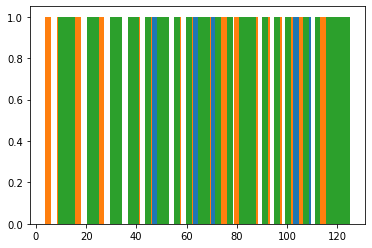

In [43]:
plt.hist(customer_df['arrival time'], bins = 50)
plt.hist(customer_df['serving time'],bins=50)
plt.hist(customer_df['departure time'],bins=50)
plt.show()

In [44]:
stats={"mean_inter_arrival_time": np.mean(customer_df['arrival time']),
"mean_service_time": np.mean(customer_df['serving time']),
"server_busy_time": np.sum(customer_df['serving time']),
"total_simulation_time": time_,}
# "total_customers_served": customer_df['customer']}

print('Simulation Report:')
print("{:<25} {:<15}".format("",""))
for k, v in stats.items():
    Value = v
    print("{:<25} {:<15}".format(k, Value))

Simulation Report:
                                         
mean_inter_arrival_time   62.41366666666668
mean_service_time         63.09233333333334
server_busy_time          1892.7700000000002
total_simulation_time     124.98051451003656


In [31]:
customer_df['customer']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
Name: customer, dtype: int64

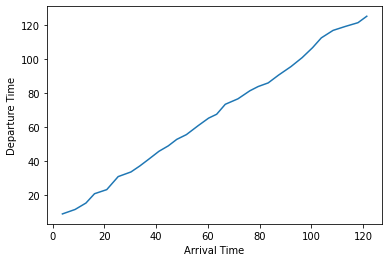

In [45]:
plt.plot(customer_df['arrival time'], customer_df['departure time'])
plt.xlabel('Arrival Time')
plt.ylabel('Departure Time')
plt.show()

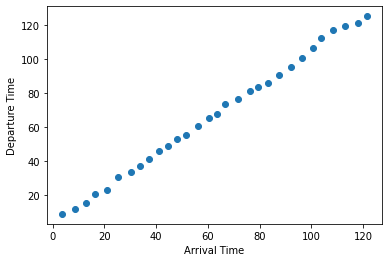

In [46]:
plt.scatter(customer_df['arrival time'], customer_df['departure time'])
plt.xlabel('Arrival Time')
plt.ylabel('Departure Time')
plt.show()

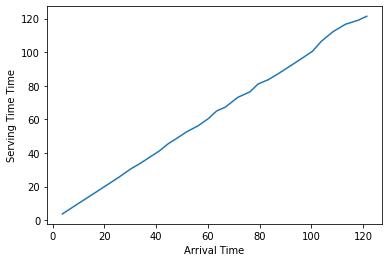

In [47]:
plt.plot(customer_df['arrival time'], customer_df['serving time'])
plt.xlabel('Arrival Time')
plt.ylabel('Serving Time Time')
plt.show()

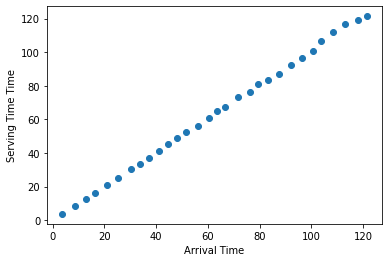

In [48]:
plt.scatter(customer_df['arrival time'], customer_df['serving time'])
plt.xlabel('Arrival Time')
plt.ylabel('Serving Time Time')
plt.show()